In [1]:
import os
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime

from fbprophet import Prophet

In [2]:
df_sales = pd.read_csv('sales_train_v2.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'],  dayfirst=True)

In [3]:
df_sales_fbprophet = df_sales.loc[(df_sales['item_cnt_day']>0)&
                                ((df_sales['item_id']==20949)) &
                               (df_sales['date_block_num']<34)]

df_sales_fbprophet = df_sales_fbprophet.drop(['date','shop_id','item_id','item_price'],axis=1)
df_sales_fbprophet

,date_block_num,item_cnt_day
352379,3,12.0
352399,3,13.0
352400,3,4.0
352401,3,4.0
352455,3,2.0
...,...,...
2930644,33,1.0
2930645,33,2.0
2930646,33,3.0
2930647,33,2.0


In [4]:
# date_block_num - a consecutive month number. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
df_sales_fbprophet['date_month'] = datetime.datetime(2013, 1, 31).date() + df_sales_fbprophet['date_block_num'].apply(pd.offsets.MonthEnd) 
df_sales_fbprophet = df_sales_fbprophet.groupby(['date_month','date_block_num'])['item_cnt_day'].sum().reset_index(name='item_cnt_month')
df_sales_fbprophet

INFO:numexpr.utils:NumExpr defaulting to 1 threads.


,date_month,date_block_num,item_cnt_month
0,2013-04-30,3,255.0
1,2013-05-31,4,3727.0
2,2013-06-30,5,8424.0
3,2013-07-31,6,7269.0
4,2013-08-31,7,7296.0
5,2013-09-30,8,7945.0
6,2013-10-31,9,7738.0
7,2013-11-30,10,8537.0
8,2013-12-31,11,12557.0
9,2014-01-31,12,7329.0


In [5]:
df_sales_fbprophet = df_sales_fbprophet.rename(columns={"date_month": "ds", "item_cnt_month": "y"})
df_sales_fbprophet

,ds,date_block_num,y
0,2013-04-30,3,255.0
1,2013-05-31,4,3727.0
2,2013-06-30,5,8424.0
3,2013-07-31,6,7269.0
4,2013-08-31,7,7296.0
5,2013-09-30,8,7945.0
6,2013-10-31,9,7738.0
7,2013-11-30,10,8537.0
8,2013-12-31,11,12557.0
9,2014-01-31,12,7329.0


In [6]:
# put in limits
df_sales_fbprophet['floor']=0
df_sales_fbprophet['cap']=df_sales_fbprophet['y'].max()

In [7]:
m = Prophet(growth='logistic')
m.fit(df_sales_fbprophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.


In [8]:
# find how many periods we need by finding the last month
days_to_predict = pd.to_datetime('2016-1-31') - df_sales_fbprophet['ds'].max()
months_to_predict = round(days_to_predict.days/31)

In [9]:
# predict 2 months into the future
future = m.make_future_dataframe(periods=months_to_predict, freq='M')
future['floor']=0
future['cap']=df_sales_fbprophet['y'].max()

future.tail()

,ds,floor,cap
29,2015-09-30,0,12557.0
30,2015-10-31,0,12557.0
31,2015-11-30,0,12557.0
32,2015-12-31,0,12557.0
33,2016-01-31,0,12557.0


In [10]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
29,2015-09-30,3538.567547,2779.489314,4345.476137
30,2015-10-31,4151.101849,3268.064432,4965.192055
31,2015-11-30,5855.155875,5111.802003,6714.489105
32,2015-12-31,11222.583249,10363.522438,11965.301351
33,2016-01-31,8357.516447,7516.341407,9237.645645


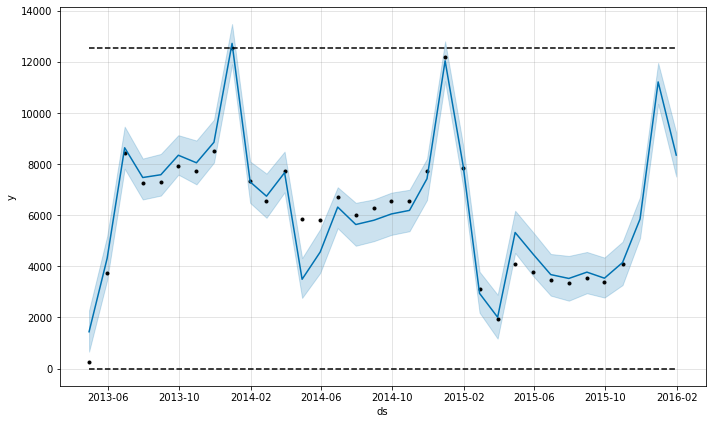

In [11]:
fig1 = m.plot(forecast)

In [12]:
# forecast
forecast[['ds','yhat']]

,ds,yhat
0,2013-04-30,1440.902498
1,2013-05-31,4318.078213
2,2013-06-30,8645.433248
3,2013-07-31,7479.762605
4,2013-08-31,7588.848205
5,2013-09-30,8352.375708
6,2013-10-31,8057.022496
7,2013-11-30,8861.237628
8,2013-12-31,12730.852813
9,2014-01-31,7309.228546


In [13]:
# forecast for Nov 2015
forecast.loc[(forecast['ds']==pd.to_datetime('2015-11-30'))]['yhat']

31    5855.155875
Name: yhat, dtype: float64